# Proyecto de Predicción de Producción Agrícola 

Imports

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import itertools

In [2]:
weather_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/weather.csv'
agri_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/agri.csv'

weather_df = pd.read_csv(weather_file_path)
agri_df = pd.read_csv(agri_file_path, encoding='latin1')

In [5]:
#Normalizar los nombres de las columnas en el dataset agrícola
agri_df.columns = agri_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Crear una columna de fecha en el dataset agrícola
agri_df['date'] = pd.to_datetime(agri_df['año'].astype(str) + '-01-01')

# Crear una columna de fecha en el dataset meteorológico
weather_df['date'] = pd.to_datetime(weather_df['date_time'])

In [6]:
# Verificar que las ciudades en ambos conjuntos de datos coincidan
agri_df['ciudad'] = agri_df['ciudad'].str.strip().str.lower()
weather_df['city'] = weather_df['city'].str.strip().str.lower()

print(weather_df.head())
print(agri_df.head())

        city   date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  barcelona  2008-07-01        27        22           0.0     14.5        6   
1  barcelona  2008-07-02        25        19           0.0     14.5        6   
2  barcelona  2008-07-03        25        20           0.0     14.5        6   
3  barcelona  2008-07-04        25        19           0.0     14.5        6   
4  barcelona  2008-07-05        27        20           0.0     14.5        6   

   uvIndex.1  moon_illumination  moonrise  ... WindGustKmph cloudcover  \
0          6                  4  04:04 AM  ...           19          8   
1          6                  0  05:07 AM  ...           11          6   
2          6                  0  06:21 AM  ...           14         22   
3          6                  3  07:41 AM  ...           22          5   
4          6                 10  08:59 AM  ...           18          5   

  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0     

In [49]:
print(agri_df.head())

    año     ciudad cultivo  superficie_ha  produccion_toneladas       date
0  2008     madrid   Trigo           1500                  3000 2008-01-01
1  2008  barcelona   MaÃ­z           1200                  2500 2008-01-01
2  2008    sevilla   Olivo           2000                  4000 2008-01-01
3  2008   valencia     Vid           1800                  3500 2008-01-01
4  2008     bilbao   Trigo           1100                  2200 2008-01-01


In [10]:
# Crear las columnas de `year` y `month` en el dataset meteorológico
weather_df['year'] = pd.DatetimeIndex(weather_df['date_time']).year
weather_df['month'] = pd.DatetimeIndex(weather_df['date_time']).month

2. Unir los datos

Una vez que hemos verificado y normalizado los datos, unimos los conjuntos de datos usando las columnas de ciudad y fecha.

In [11]:
combined_df = pd.merge(agri_df, weather_df, left_on=['año', 'ciudad'], right_on=['year', 'city'], how='inner')
combined_df.head()

,año,ciudad,cultivo,superficie_ha,produccion_toneladas,date_x,city,date_time,maxtempC,mintempC,...,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,date_y,year,month
0,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-01,33,17,...,28,0.0,1014,33,10,203,8,2008-07-01,2008,7
1,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-02,27,17,...,36,0.0,1012,27,10,215,14,2008-07-02,2008,7
2,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-03,27,14,...,34,0.0,1015,27,10,269,7,2008-07-03,2008,7
3,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-04,31,13,...,30,0.0,1016,31,10,156,9,2008-07-04,2008,7
4,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-05,32,18,...,44,0.0,1015,32,10,256,13,2008-07-05,2008,7


# Análisis Descriptivo y Visualización.

Análisis Descritivo:

In [13]:
# Estadísticas descriptivas
descriptive_stats = combined_df.describe()
descriptive_stats

,año,superficie_ha,produccion_toneladas,date_x,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,...,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,date_y,year,month
count,30688.000000,30688.000000,30688.000000,30688,30688.000000,30688.000000,30688.000000,30688.000000,30688.000000,30688.000000,...,30688.000000,30688.000000,30688.000000,30688.000000,30688.000000,30688.000000,30688.000000,30688,30688.000000,30688.000000
mean,2013.236444,1502.355970,2971.386210,2013-03-28 00:22:31.407716352,21.483349,13.496774,0.002066,10.693571,4.733935,4.733935,...,71.829347,1.313953,1016.634417,21.483349,9.465361,176.770822,11.166286,2013-09-30 11:59:59.999999744,2013.236444,6.666058
min,2008.000000,900.000000,1800.000000,2008-01-01 00:00:00,0.000000,-6.000000,0.000000,3.400000,1.000000,1.000000,...,14.000000,0.000000,982.000000,0.000000,1.000000,5.000000,1.000000,2008-07-01 00:00:00,2008.000000,1.000000
25%,2011.000000,1250.000000,2500.000000,2011-01-01 00:00:00,15.000000,9.000000,0.000000,8.700000,4.000000,4.000000,...,66.000000,0.000000,1013.000000,15.000000,9.000000,113.000000,7.000000,2011-02-14 18:00:00,2011.000000,4.000000
50%,2013.000000,1425.000000,2850.000000,2013-01-01 00:00:00,22.000000,14.000000,0.000000,11.600000,5.000000,5.000000,...,75.000000,0.000000,1016.000000,22.000000,10.000000,176.000000,10.000000,2013-09-30 12:00:00,2013.000000,7.000000
75%,2016.000000,1725.000000,3425.000000,2016-01-01 00:00:00,27.000000,19.000000,0.000000,11.600000,6.000000,6.000000,...,82.000000,1.000000,1020.000000,27.000000,10.000000,239.000000,14.000000,2016-05-16 06:00:00,2016.000000,10.000000
max,2018.000000,2200.000000,4400.000000,2018-01-01 00:00:00,45.000000,29.000000,5.900000,14.500000,9.000000,9.000000,...,99.000000,109.800000,1043.000000,45.000000,10.000000,355.000000,55.000000,2018-12-31 00:00:00,2018.000000,12.000000
std,3.038753,363.513214,696.101486,NaN,7.356269,5.859278,0.060904,2.693154,1.402117,1.402117,...,15.032476,3.357948,6.473107,7.356269,1.102218,80.808618,5.506445,NaN,3.038753,3.444734


Visualización de Relaciones entre Variables:

- Temperatura y Producción:

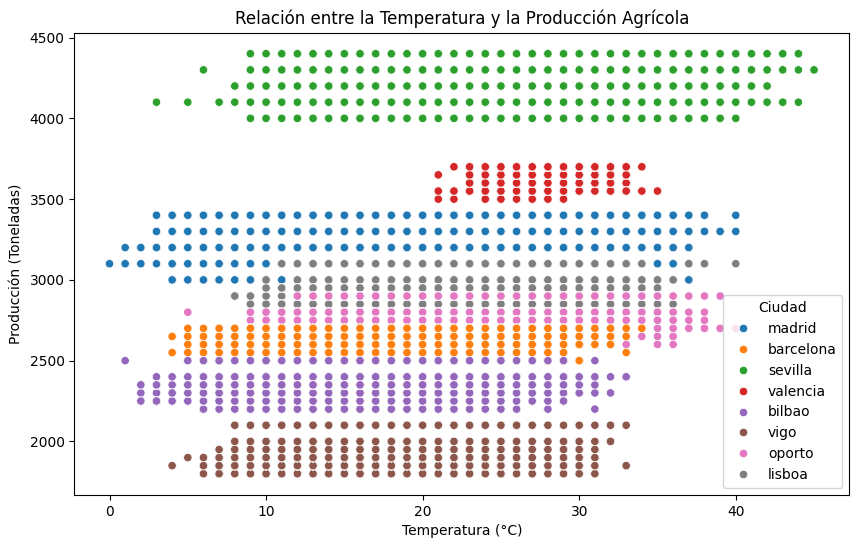

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='tempC', y='produccion_toneladas', hue='ciudad')
plt.title('Relación entre la Temperatura y la Producción Agrícola')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Producción (Toneladas)')
plt.legend(title='Ciudad')
plt.show()


- Índice Ultravioleta y Producción:

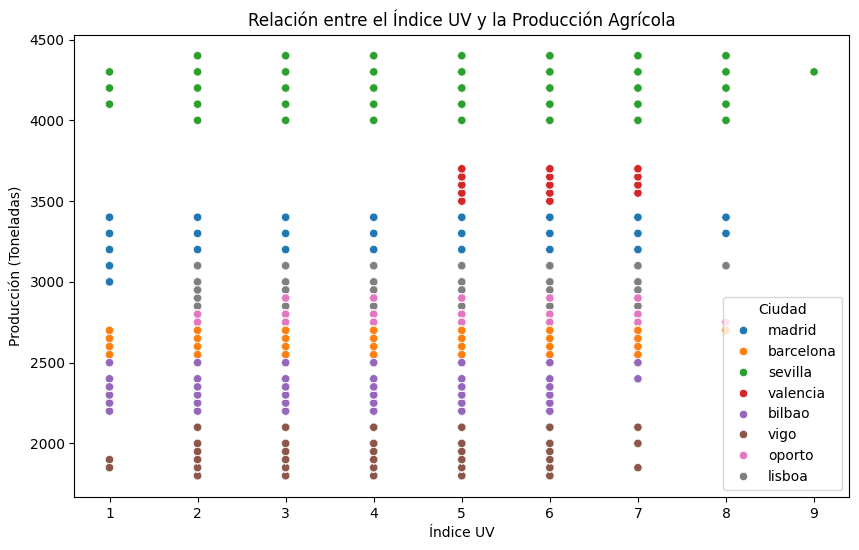

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='uvIndex', y='produccion_toneladas', hue='ciudad')
plt.title('Relación entre el Índice UV y la Producción Agrícola')
plt.xlabel('Índice UV')
plt.ylabel('Producción (Toneladas)')
plt.legend(title='Ciudad')
plt.show()

- Precipitación y Producción:

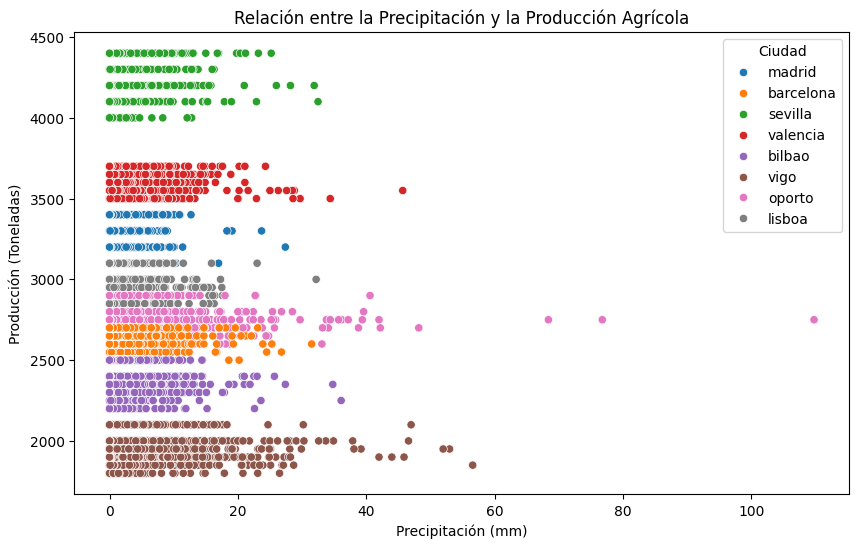

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='precipMM', y='produccion_toneladas', hue='ciudad')
plt.title('Relación entre la Precipitación y la Producción Agrícola')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Producción (Toneladas)')
plt.legend(title='Ciudad')
plt.show()

- Horas de sol y Producción:

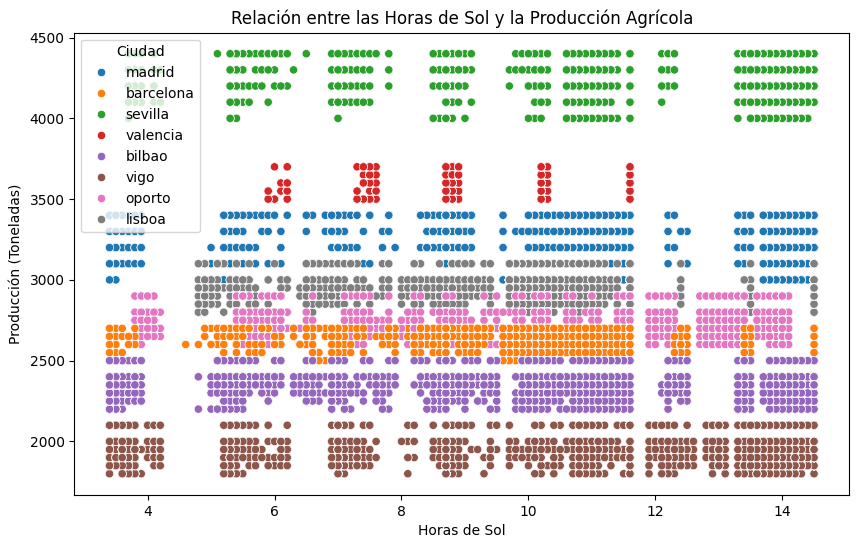

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='sunHour', y='produccion_toneladas', hue='ciudad')
plt.title('Relación entre las Horas de Sol y la Producción Agrícola')
plt.xlabel('Horas de Sol')
plt.ylabel('Producción (Toneladas)')
plt.legend(title='Ciudad')
plt.show()

3: Preparación de Datos para Modelado
Calcular las medias mensuales de las variables meteorológicas:

In [18]:
# Seleccionar las columnas relevantes
data = combined_df[['ciudad', 'date_y', 'produccion_toneladas', 'tempC', 'uvIndex', 'precipMM', 'sunHour']]

# Crear columnas para el año y el mes
data['year'] = pd.DatetimeIndex(data['date_y']).year
data['month'] = pd.DatetimeIndex(data['date_y']).month

# Calcular las medias mensuales de las variables de interés
monthly_means = data.groupby(['ciudad', 'year', 'month']).agg({
    'tempC': 'mean',
    'uvIndex': 'mean',
    'precipMM': 'mean',
    'sunHour': 'mean',
    'produccion_toneladas': 'mean'
}).reset_index()

# Crear una columna de fecha para la serie temporal
monthly_means['date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(day=1))

# Establecer la columna de fecha como índice
monthly_means.set_index('date', inplace=True)

# Ordenar los datos por fecha
monthly_means.sort_index(inplace=True)

# Mostrar las primeras filas del dataframe resultante
monthly_means.head()

/tmp/ipykernel_20236/3786952819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.DatetimeIndex(data['date_y']).year
/tmp/ipykernel_20236/3786952819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.DatetimeIndex(data['date_y']).month


,ciudad,year,month,tempC,uvIndex,precipMM,sunHour,produccion_toneladas
date,,,,,,,,
2008-07-01,barcelona,2008,7,25.451613,5.935484,0.300000,14.435484,2500.0
2008-07-01,vigo,2008,7,23.096774,4.967742,0.596774,13.670968,1800.0
2008-07-01,valencia,2008,7,25.580645,5.645161,4.912903,9.074194,3500.0
2008-07-01,lisboa,2008,7,24.741935,5.612903,0.000000,12.954839,2800.0
2008-07-01,sevilla,2008,7,36.258065,7.000000,0.000000,14.270968,4000.0


4. SARIMAX

Dividir los Datos en Entrenamiento y Prueba:

In [19]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(monthly_means) * 0.8)
train, test = monthly_means.iloc[:train_size], monthly_means.iloc[train_size:]

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
train.shape, test.shape

((806, 8), (202, 8))

Realizamos predicciones y evaluamos el modelo:

In [23]:
# Definir el modelo SARIMAX
model = SARIMAX(train['produccion_toneladas'],
                exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                order=(1, 1, 1),  # Parámetros del modelo ARIMA
                seasonal_order=(1, 1, 1, 12))  # Parámetros de estacionalidad

# Entrenar el modelo
model_fit = model.fit(disp=False)

# Mostrar el resumen del modelo
model_fit.summary()

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:               produccion_toneladas   No. Observations:                  806
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6146.585
Date:                            Tue, 06 Aug 2024   AIC                          12311.169
Time:                                    17:25:29   BIC                          12353.252
Sample:                                         0   HQIC                         12327.342
                                            - 806                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tempC        248.6540     16.268     15.285      0.000     216.769     280.539
uvIndex    -1021.4869     90.805    -11.249      0.000   -1199.462    -843.512
precipMM     -95.5405     15.468     -6.177      0.000    -125.858     -65.223
sunHour     -109.2755     12.524     -8.726      0.000    -133.821     -84.730
ar.L1         -0.0559      0.037     -1.507      0.132      -0.129       0.017
ma.L1         -1.0000      3.098     -0.323      0.747      -7.072       5.072
ar.S.L12       0.0360      0.037      0.978      0.328      -0.036       0.108
ma.S.L12      -0.9999      3.103     -0.322      0.747      -7.081       5.082
sigma2       2.93e+05      0.001   5.86e+08      0.000    2.93e+05    2.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.89   Prob(JB):                         0.04
Heteroskedasticity (H):               0.94   Skew:                            -0.00
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+26. Standard errors may be unstable.
"""

In [25]:
# Hacer predicciones sobre el conjunto de prueba
test_exog = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Evaluar el modelo utilizando métricas adecuadas
mse = mean_squared_error(test['produccion_toneladas'], predictions)
rmse = mse ** 0.5

# Mostrar el RMSE
print(f'RMSE: {rmse}')


RMSE: 554.6611162684898


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Visualizamos las predicciones:

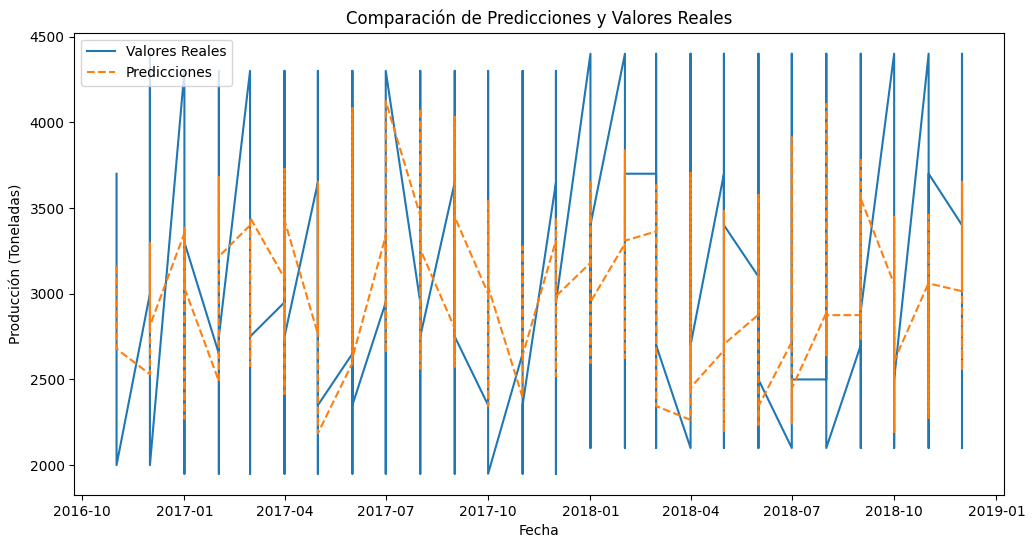

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['produccion_toneladas'], label='Valores Reales')
plt.plot(test.index, predictions, label='Predicciones', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Producción (Toneladas)')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()
plt.show()

- Optimizamos el Modelo:

In [28]:
# Definir rangos para la búsqueda de hiperparámetros
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train['produccion_toneladas'],
                          exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f'Best SARIMA{best_pdq}x{best_seasonal_pdq}12 - AIC:{best_aic}')

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

Best SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:12088.602411407199


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Entrenar el Mejor Modelo SARIMAX:

In [31]:
# Entrenar el mejor modelo SARIMAX
best_model = SARIMAX(train['produccion_toneladas'],
                     exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                     order=best_pdq,
                     seasonal_order=best_seasonal_pdq)
best_model_fit = best_model.fit(disp=False)

# Hacer predicciones sobre el conjunto de prueba
best_predictions = best_model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Evaluar el modelo utilizando el RMSE
best_mse = mean_squared_error(test['produccion_toneladas'], best_predictions)
best_rmse = best_mse ** 0.5

print(f'RMSE del Modelo Optimizado: {best_rmse}')

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE del Modelo Optimizado: 555.2592892917183


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Visualización de las Predicciones del Modelo Optimizado


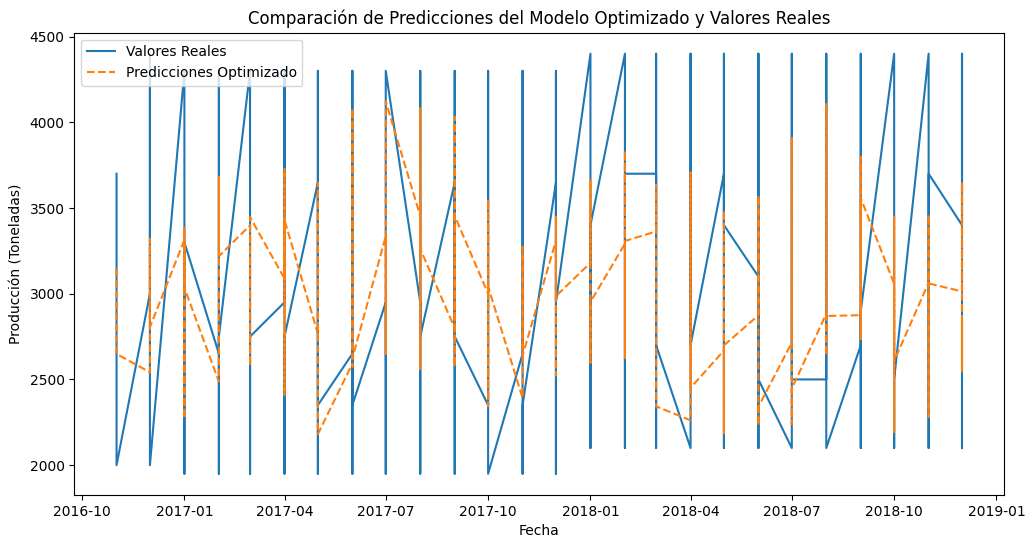

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['produccion_toneladas'], label='Valores Reales')
plt.plot(test.index, best_predictions, label='Predicciones Optimizado', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Producción (Toneladas)')
plt.title('Comparación de Predicciones del Modelo Optimizado y Valores Reales')
plt.legend()
plt.show()

In [33]:
print(f'RMSE del Modelo Inicial: {rmse}')
print(f'RMSE del Modelo Optimizado: {best_rmse}')

RMSE del Modelo Inicial: 554.6611162684898
RMSE del Modelo Optimizado: 555.2592892917183


Longitud del Conjunto de Prueba: 202
Longitud de las Predicciones: 202
Longitud del Conjunto de Prueba: 202
Longitud de las Predicciones: 202


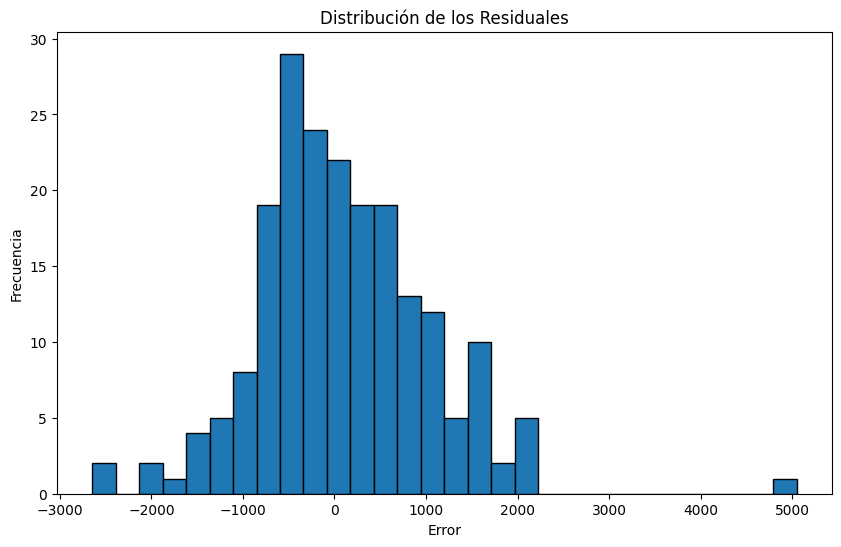

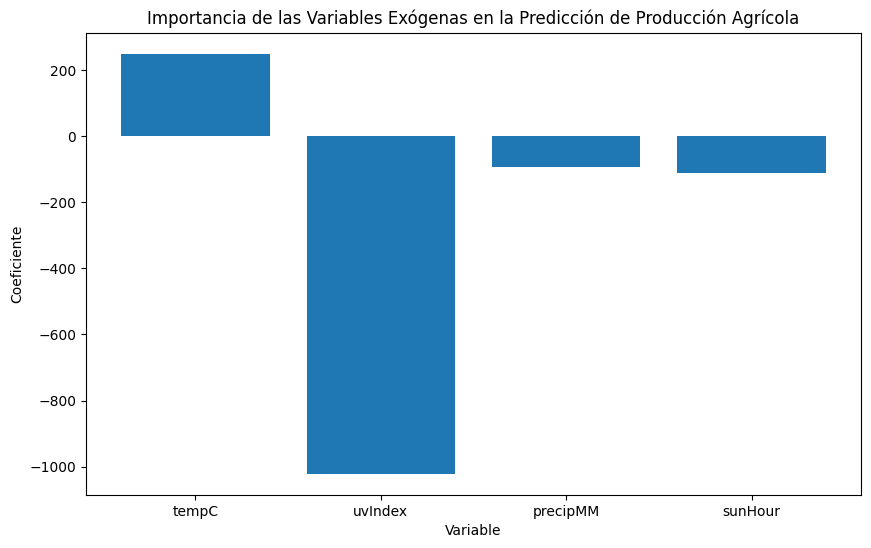

In [39]:
# Asegurar que el índice sea numérico para evitar problemas con las fechas
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Hacer predicciones sobre el conjunto de prueba usando el índice numérico
best_predictions = best_model_fit.predict(start=test.index[0], end=test.index[-1], exog=test_exog)

# Verificar las longitudes de las predicciones y el conjunto de prueba
print(f'Longitud del Conjunto de Prueba: {len(test)}')
print(f'Longitud de las Predicciones: {len(best_predictions)}')

# Alinear las predicciones con el índice del conjunto de prueba
best_predictions.index = test.index

# Verificar nuevamente las longitudes de las predicciones y el conjunto de prueba
print(f'Longitud del Conjunto de Prueba: {len(test)}')
print(f'Longitud de las Predicciones: {len(best_predictions)}')

# Análisis de Errores
residuals = test['produccion_toneladas'] - best_predictions
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Distribución de los Residuales')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de la Importancia de las Variables

coefficients = best_model_fit.params
variables = ['tempC', 'uvIndex', 'precipMM', 'sunHour']
importance = coefficients[variables]

plt.figure(figsize=(10, 6))
plt.bar(variables, importance)
plt.title('Importancia de las Variables Exógenas en la Predicción de Producción Agrícola')
plt.xlabel('Variable')
plt.ylabel('Coeficiente')
plt.show()

Interpretación de Resultados:
Los coeficientes del modelo indican la influencia de cada variable meteorológica en la producción agrícola.
Es importante tener en cuenta las condiciones climáticas a la hora de planificar la producción agrícola.
Las futuras investigaciones podrían incluir más variables exógenas y probar otros modelos de series temporales para mejorar la precisión.

Hemos utilizado el modelo SARIMAX para predecir la producción agrícola. Vamos a probar otro modelo de aprendizaje automático y luego optimizar ambos modelos para seleccionar el mejor.

# Modelos Alternativo: 

- Random Forest

In [41]:
# Preparar los datos para el modelo de Random Forest
X_train = train[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_train = train['produccion_toneladas']
X_test = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_test = test['produccion_toneladas']

# Definir el modelo de Random Forest
rf = RandomForestRegressor(random_state=42)

# Definir los hiperparámetros para GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Hacer predicciones sobre el conjunto de prueba
rf_predictions = best_rf.predict(X_test)

# Evaluar el modelo utilizando el RMSE
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = rf_mse ** 0.5

print(f'RMSE del Modelo Random Forest: {rf_rmse}')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END m

- KNN

In [46]:
# Preparar los datos para el modelo de KNN
X_train = train[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_train = train['produccion_toneladas']
X_test = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_test = test['produccion_toneladas']

# Definir el modelo de KNN
knn = KNeighborsRegressor()

# Definir los hiperparámetros para GridSearch
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Realizar GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)

# Obtener el mejor modelo
best_knn = grid_search_knn.best_estimator_

# Hacer predicciones sobre el conjunto de prueba
knn_predictions = best_knn.predict(X_test)

# Evaluar el modelo utilizando el RMSE
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = knn_mse ** 0.5

print(f'RMSE del Modelo KNN: {knn_rmse}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.0s[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.0s

[CV] END .....algorithm=auto, n_neighbors=3, weights=uniform; total time=   0.0s[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.0s

[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END .....algorithm=auto, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END .....algorithm=auto

Comparación de Modelos: 
Comparamos el rendimiento del modelo SARIMAX, Random Forest y KNN para seleccionar el mejor:

In [47]:
print(f'RMSE del Modelo SARIMAX Optimizado: {best_rmse}')
print(f'RMSE del Modelo Random Forest: {rf_rmse}')
print(f'RMSE del Modelo KNN: {knn_rmse}')

# Seleccionar el mejor modelo
if best_rmse < rf_rmse and best_rmse < knn_rmse:
    best_model_name = 'SARIMAX'
    best_model = best_model_fit
    best_predictions = best_model_fit.predict(start=0, end=len(test) - 1, exog=test_exog)
elif rf_rmse < best_rmse and rf_rmse < knn_rmse:
    best_model_name = 'Random Forest'
    best_model = best_rf
    best_predictions = rf_predictions
else:
    best_model_name = 'KNN'
    best_model = best_knn
    best_predictions = knn_predictions

print(f'El mejor modelo es: {best_model_name}')


RMSE del Modelo SARIMAX Optimizado: 953.9626416495246
RMSE del Modelo Random Forest: 469.3773877307556
RMSE del Modelo KNN: 471.28974186593376
El mejor modelo es: Random Forest


# DESPLIEGUE DEL MODELO

Implementación de la Aplicación Web con Streamlit

In [48]:
import joblib
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Cargar los datasets
weather_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/weather.csv'
agri_file_path = '/workspaces/proyectfinaltour/data/processed/unificado/agri.csv'

weather_df = pd.read_csv(weather_file_path)
agri_df = pd.read_csv(agri_file_path, encoding='latin1')

# Normalizar los nombres de las columnas en el dataset agrícola
agri_df.columns = agri_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Crear una columna de fecha en el dataset agrícola
agri_df['date'] = pd.to_datetime(agri_df['año'].astype(str) + '-01-01')

# Crear una columna de fecha en el dataset meteorológico
weather_df['date'] = pd.to_datetime(weather_df['date_time'])

# Verificar que las ciudades en ambos conjuntos de datos coincidan
agri_df['ciudad'] = agri_df['ciudad'].str.strip().str.lower()
weather_df['city'] = weather_df['city'].str.strip().str.lower()

# Crear las columnas de `year` y `month` en el dataset meteorológico
weather_df['year'] = pd.DatetimeIndex(weather_df['date_time']).year
weather_df['month'] = pd.DatetimeIndex(weather_df['date_time']).month

# Unir los datos agrícolas y meteorológicos por año y ciudad
combined_df = pd.merge(agri_df, weather_df, left_on=['año', 'ciudad'], right_on=['year', 'city'], how='inner')

# Seleccionar las columnas relevantes
data = combined_df[['ciudad', 'date_y', 'produccion_toneladas', 'tempC', 'uvIndex', 'precipMM', 'sunHour']]

# Crear columnas para el año y el mes
data['year'] = pd.DatetimeIndex(data['date_y']).year
data['month'] = pd.DatetimeIndex(data['date_y']).month

# Calcular las medias mensuales de las variables de interés
monthly_means = data.groupby(['ciudad', 'year', 'month']).agg({
    'tempC': 'mean',
    'uvIndex': 'mean',
    'precipMM': 'mean',
    'sunHour': 'mean',
    'produccion_toneladas': 'mean'
}).reset_index()

# Crear una columna de fecha para la serie temporal
monthly_means['date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(day=1))

# Establecer la columna de fecha como índice
monthly_means.set_index('date', inplace=True)

# Ordenar los datos por fecha
monthly_means.sort_index(inplace=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(monthly_means) * 0.8)
train, test = monthly_means.iloc[:train_size], monthly_means.iloc[train_size:]

# Definir y entrenar el modelo SARIMAX
model_sarimax = SARIMAX(train['produccion_toneladas'],
                exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

model_fit_sarimax = model_sarimax.fit(disp=False)

# Hacer predicciones con SARIMAX
test_exog = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
predictions_sarimax = model_fit_sarimax.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Evaluar el modelo SARIMAX utilizando el RMSE
mse_sarimax = mean_squared_error(test['produccion_toneladas'], predictions_sarimax)
rmse_sarimax = mse_sarimax ** 0.5

# Entrenar y evaluar el modelo Random Forest
X_train = train[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_train = train['produccion_toneladas']
X_test = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
y_test = test['produccion_toneladas']

rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
predictions_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = mse_rf ** 0.5

# Entrenar y evaluar el modelo KNN
knn = KNeighborsRegressor()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=3, n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
predictions_knn = best_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, predictions_knn)
rmse_knn = mse_knn ** 0.5

# Comparar los modelos y seleccionar el mejor
if rmse_sarimax < rmse_rf and rmse_sarimax < rmse_knn:
    best_model_name = 'SARIMAX'
    best_model = model_fit_sarimax
    best_predictions = predictions_sarimax
elif rmse_rf < rmse_sarimax and rmse_rf < rmse_knn:
    best_model_name = 'Random Forest'
    best_model = best_rf
    best_predictions = predictions_rf
else:
    best_model_name = 'KNN'
    best_model = best_knn
    best_predictions = predictions_knn

# Guardar el nombre del mejor modelo
joblib.dump(best_model_name, 'best_model_name.pkl')

# Guardar el mejor modelo
if best_model_name == 'SARIMAX':
    joblib.dump(best_model, 'best_model_sarimax.pkl')
elif best_model_name == 'Random Forest':
    joblib.dump(best_model, 'best_model_rf.pkl')
else:
    joblib.dump(best_model, 'best_model_knn.pkl')


/tmp/ipykernel_20236/1259428632.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.DatetimeIndex(data['date_y']).year
/tmp/ipykernel_20236/1259428632.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.DatetimeIndex(data['date_y']).month
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self.

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estim